# 🚀 Email Phishing Detection - Feature Engineering & Evaluation

**Complete Pipeline: From Cleaned Data → Automatically Selected Features**

## Overview

This notebook:
1. **Creates 15 engineered features** from cleaned email data
2. **Evaluates all features** using multiple methods:
   - Feature Importance (Random Forest)
   - Statistical Significance Tests
   - Information Value (IV)
3. **Automatically selects optimal features** based on:
   - Statistical significance (p < 0.05)
   - Feature importance threshold (> 0.01)
   - Cumulative importance (elbow point or 80% threshold)

---

## Table of Contents

### Part 1: Feature Engineering
- 1.1 Setup & Data Loading
- 1.2 Original Features (5 existing features)
- 1.2.1 Add is_night Feature (1 new feature)
- 1.3 Temporal Risk Scores (2 features)
- 1.4 Regional Features (3 features)
- 1.5 Sender Historical Features (2 features - time-aware)
- 1.6 Sender Temporal Features (4 features - modified to time-aware)
- 1.7 Sender Newness Feature (0 features - combined into 1.5)
- 1.8 Interaction Features (1 feature)
- 1.9 Final Dataset Assembly (15 features + target)

### Part 2: Feature Evaluation & Selection
- 2.1 Data Preparation
- 2.2 Feature Importance (Random Forest)
- 2.3 Statistical Significance Tests
- 2.4 Information Value (Optional)
- 2.5 Automatic Feature Selection
- 2.6 Comprehensive Visualizations
- 2.7 Summary

---


---
# 📦 PART 1: FEATURE ENGINEERING
---

## 1.1 Setup & Data Loading

In [34]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plotting settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✅ Libraries loaded successfully")

✅ Libraries loaded successfully


In [35]:
# ============================================================
# LOAD YOUR CLEANED DATA
# ============================================================

file_path = "cleaned_date_merged_data.csv"

print("="*80)
print("LOADING CLEANED DATA")
print("="*80)

df = pd.read_csv(file_path)
df['date'] = pd.to_datetime(df['date'])

print(f"\n✅ Data loaded: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"   Date range: {df['date'].min()} to {df['date'].max()}")
print(f"\n📊 Label Distribution:")
print(df['label'].value_counts())
print(f"\n   Phishing rate: {df['label'].mean()*100:.2f}%")

# Display first few rows
df.head()

LOADING CLEANED DATA

✅ Data loaded: 48,803 rows × 16 columns
   Date range: 1990-01-01 17:57:46 to 2022-12-27 10:56:49

📊 Label Distribution:
label
1    27406
0    21397
Name: count, dtype: int64

   Phishing rate: 56.16%


,sender,receiver,date,subject,body,label,urls,timezone_hours,timezone_region,year,month,day,hour,day_of_week,day_name,is_weekend
0,Young Esposito <Young@iworld.de>,user4@gvc.ceas-challenge.cc,2008-08-06 07:31:02,Never agree to be a loser,"Buck up, your troubles caused by small dimensi...",1,1,-7.0000,Americas,2008,8,6,7,2,Wednesday,0
1,Mok <ipline's1983@icable.ph>,user2.2@gvc.ceas-challenge.cc,2008-08-06 07:31:03,Befriend Jenna Jameson,\nUpgrade your sex and pleasures with these te...,1,1,-5.0000,Americas,2008,8,6,7,2,Wednesday,0
2,Daily Top 10 <Karmandeep-opengevl@universalnet...,user2.9@gvc.ceas-challenge.cc,2008-08-06 16:28:00,CNN.com Daily Top 10,>+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+...,1,1,-12.0000,Americas,2008,8,6,16,2,Wednesday,0
3,Michael Parker <ivqrnai@pobox.com>,SpamAssassin Dev <xrh@spamassassin.apache.org>,2008-08-06 07:31:20,Re: svn commit: r619753 - in /spamassassin/tru...,Would anyone object to removing .so from this ...,0,1,-6.0000,Americas,2008,8,6,7,2,Wednesday,0
4,Gretchen Suggs <externalsep1@loanofficertool.com>,user2.2@gvc.ceas-challenge.cc,2008-08-06 07:31:21,SpecialPricesPharmMoreinfo,\nWelcomeFastShippingCustomerSupport\nhttp://7...,1,1,-4.0000,Europe/Africa,2008,8,6,7,2,Wednesday,0


In [36]:
# Verify required columns exist
required_cols = ['sender', 'date', 'label', 'hour', 'day_of_week', 'month', 
                 'is_weekend', 'timezone_region']

print("Checking required columns:")
for col in required_cols:
    if col in df.columns:
        print(f"   ✅ {col}: {df[col].dtype}, {df[col].nunique()} unique values")
    else:
        print(f"   ❌ MISSING: {col}")

missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    raise ValueError(f"Missing required columns: {missing_cols}")
else:
    print(f"\n✅ All required columns present!")

Checking required columns:
   ✅ sender: object, 30756 unique values
   ✅ date: datetime64[ns], 45189 unique values
   ✅ label: int64, 2 unique values
   ✅ hour: int64, 24 unique values
   ✅ day_of_week: int64, 7 unique values
   ✅ month: int64, 12 unique values
   ✅ is_weekend: int64, 2 unique values
   ✅ timezone_region: object, 5 unique values

✅ All required columns present!


## 1.2 Original Features (Already Exist)

These features are already in your cleaned data:
- `hour` (0-23): Hour email was sent
- `day_of_week` (0-6): Day of week (0=Monday, 6=Sunday)
- `month` (1-12): Month email was sent *(removed from final features)*
- `is_weekend` (0/1): Binary flag for weekend
- `timezone_region`: Geographic region (categorical)

**Note:** We'll remove `month` in the final assembly as it showed low information value and may be dataset-specific.


In [37]:
# Verify original features
original_features = ['hour', 'day_of_week', 'month', 'is_weekend', 'timezone_region']

print("="*80)
print("ORIGINAL FEATURES")
print("="*80)

for feature in original_features:
    print(f"\n{feature}:")
    print(f"   Type: {df[feature].dtype}")
    print(f"   Unique values: {df[feature].nunique()}")
    print(f"   Range: {df[feature].min()} to {df[feature].max()}")
    if df[feature].nunique() < 20:
        print(f"   Distribution:\n{df[feature].value_counts().head()}")

print(f"\n✅ {len(original_features)} original features verified")

ORIGINAL FEATURES

hour:
   Type: int64
   Unique values: 24
   Range: 0 to 23

day_of_week:
   Type: int64
   Unique values: 7
   Range: 0 to 6
   Distribution:
day_of_week
2    15519
3    14560
4    12866
1     2274
0     1446
Name: count, dtype: int64

month:
   Type: int64
   Unique values: 12
   Range: 1 to 12
   Distribution:
month
8     40711
9      1815
7      1545
10     1078
5       639
Name: count, dtype: int64

is_weekend:
   Type: int64
   Unique values: 2
   Range: 0 to 1
   Distribution:
is_weekend
0    46665
1     2138
Name: count, dtype: int64

timezone_region:
   Type: object
   Unique values: 5
   Range: APAC to Oceania/Pacific
   Distribution:
timezone_region
Europe/Africa             27446
Americas                  12751
Middle East/South Asia     4776
APAC                       2844
Oceania/Pacific             986
Name: count, dtype: int64

✅ 5 original features verified


## 1.2.1 Add is_night Feature

Add temporal feature to capture night-time activity:
- `is_night` (0/1): Binary flag for night hours (21:00-04:00)

**Rationale:** Based on EDA showing phishing rate varies significantly by hour, with higher rates during night hours.

In [38]:
print("="*80)
print("ADDING is_night FEATURE")
print("="*80)

# Define night hours: 9 PM (21:00) to 4 AM (04:00)
df['is_night'] = ((df['hour'] >= 21) | (df['hour'] <= 4)).astype(int)

print(f"\n✅ is_night created")
print(f"   Distribution: {df['is_night'].value_counts().to_dict()}")
print(f"   Night hours defined as: 21:00-04:00 (9 PM - 4 AM)")

# EDA insight
night_phishing_rate = df[df['is_night'] == 1]['label'].mean()
day_phishing_rate = df[df['is_night'] == 0]['label'].mean()
print(f"\n💡 EDA Insight:")
print(f"   Night emails (21:00-04:00): {df['is_night'].sum():,} ({df['is_night'].mean()*100:.1f}%)")
print(f"   Phishing rate during night: {night_phishing_rate:.1%}")
print(f"   Phishing rate during day: {day_phishing_rate:.1%}")
if day_phishing_rate > 0:
    print(f"   → Night emails are {(night_phishing_rate/day_phishing_rate - 1)*100:.1f}% more likely to be phishing")

ADDING is_night FEATURE

✅ is_night created
   Distribution: {0: 33950, 1: 14853}
   Night hours defined as: 21:00-04:00 (9 PM - 4 AM)

💡 EDA Insight:
   Night emails (21:00-04:00): 14,853 (30.4%)
   Phishing rate during night: 62.9%
   Phishing rate during day: 53.2%
   → Night emails are 18.2% more likely to be phishing


## 1.3 Temporal Risk Scores

Calculate historical phishing rates for different time periods:
- `hour_risk_score`: Phishing rate for each hour (0-23)
- `weekday_risk_score`: Phishing rate for each weekday (0-6)

In [39]:
print("="*80)
print("CREATING TEMPORAL RISK SCORES")
print("="*80)

# Hour Risk Score
hour_risk = df.groupby('hour')['label'].mean()
df['hour_risk_score'] = df['hour'].map(hour_risk)

print(f"\n✅ hour_risk_score created")
print(f"   Range: [{df['hour_risk_score'].min():.3f}, {df['hour_risk_score'].max():.3f}]")
print(f"   Mean: {df['hour_risk_score'].mean():.3f}")

# Weekday Risk Score
weekday_risk = df.groupby('day_of_week')['label'].mean()
df['weekday_risk_score'] = df['day_of_week'].map(weekday_risk)

print(f"\n✅ weekday_risk_score created")
print(f"   Range: [{df['weekday_risk_score'].min():.3f}, {df['weekday_risk_score'].max():.3f}]")
print(f"   Mean: {df['weekday_risk_score'].mean():.3f}")

# Display risk scores
print(f"\n📊 Hour Risk Scores:")
print(hour_risk.to_frame('phishing_rate'))

print(f"\n📊 Weekday Risk Scores:")
weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_risk_df = pd.DataFrame({
    'day': weekday_names,
    'phishing_rate': weekday_risk.values
})
print(weekday_risk_df)

CREATING TEMPORAL RISK SCORES

✅ hour_risk_score created
   Range: [0.368, 0.672]
   Mean: 0.562

✅ weekday_risk_score created
   Range: [0.524, 0.705]
   Mean: 0.562

📊 Hour Risk Scores:
      phishing_rate
hour               
0            0.5998
1            0.6540
2            0.6406
3            0.6293
4            0.6217
5            0.5364
6            0.5333
7            0.5062
8            0.3676
9            0.4877
10           0.4497
11           0.5087
12           0.5071
13           0.5070
14           0.5110
15           0.5109
16           0.6152
17           0.6552
18           0.6164
19           0.6178
20           0.6382
21           0.6092
22           0.6721
23           0.6125

📊 Weekday Risk Scores:
         day  phishing_rate
0     Monday         0.6189
1    Tuesday         0.5712
2  Wednesday         0.5502
3   Thursday         0.5819
4     Friday         0.5242
5   Saturday         0.6667
6     Sunday         0.7051


## 1.4 Regional Features

Create regional risk features:
- `region_risk_score`: Historical phishing rate by region
- `is_middle_east`: Binary flag for Middle East/South Asia (93% phishing rate!)

In [40]:
print("="*80)
print("CREATING REGIONAL FEATURES")
print("="*80)

# Region Risk Score
region_risk = df.groupby('timezone_region')['label'].mean()
df['region_risk_score'] = df['timezone_region'].map(region_risk)

print(f"\n✅ region_risk_score created")
print(f"   Range: [{df['region_risk_score'].min():.3f}, {df['region_risk_score'].max():.3f}]")

# Is Middle East Flag
df['is_middle_east'] = (df['timezone_region'] == 'Middle East/South Asia').astype(int)

print(f"\n✅ is_middle_east created")
print(f"   Distribution: {df['is_middle_east'].value_counts().to_dict()}")

# Display regional statistics
print(f"\n📊 Regional Phishing Rates:")
regional_stats = df.groupby('timezone_region').agg({
    'label': ['count', 'sum', 'mean']
})
regional_stats.columns = ['total_emails', 'phishing_count', 'phishing_rate']
regional_stats = regional_stats.sort_values('phishing_rate', ascending=False)
print(regional_stats)

CREATING REGIONAL FEATURES

✅ region_risk_score created
   Range: [0.072, 0.932]

✅ is_middle_east created
   Distribution: {0: 44027, 1: 4776}

📊 Regional Phishing Rates:
                        total_emails  phishing_count  phishing_rate
timezone_region                                                    
Middle East/South Asia          4776            4453         0.9324
APAC                            2844            2175         0.7648
Europe/Africa                  27446           16379         0.5968
Americas                       12751            4328         0.3394
Oceania/Pacific                  986              71         0.0720


## 1.5 Sender Historical Features (Time-Aware)

**IMPORTANT:** These features are calculated in a **time-aware manner** to prevent data leakage.

For each email at time T, we only use information from emails that came BEFORE time T.

Features created:
- `sender_historical_phishing_rate`: Historical phishing rate of this sender (before current email)
- `sender_historical_count`: Number of previous emails from this sender

**Time-aware calculation ensures:**
1. No future information is used
2. Features update as sender sends more emails
3. First emails from sender = 0 or baseline rate
4. Ready for production deployment

**Note:** We removed `is_first_sender_email` and `is_burst_sender` as they are redundant with `sender_historical_count` and the temporal features.

In [41]:
print("="*80)
print("CREATING TIME-AWARE SENDER FEATURES (NO LEAKAGE!)")
print("="*80)

# Sort by sender and date (CRITICAL for time-awareness)
df = df.sort_values(['sender', 'date']).reset_index(drop=True)

print(f"\n📊 Data sorted by sender and date for time-aware calculation")

# ============================================================
# TIME-AWARE: Calculate sender historical phishing rate
# For each email, use ONLY emails that came BEFORE it
# ============================================================

# Count previous emails for this sender (0 for first, 1 for second, etc.)
df['sender_historical_count'] = df.groupby('sender').cumcount()

# Calculate cumulative phishing count
df['_cumsum_phishing'] = df.groupby('sender')['label'].cumsum()

# Shift to get PREVIOUS phishing count (excludes current email)
df['_prev_phishing'] = df.groupby('sender')['_cumsum_phishing'].shift(1).fillna(0)

# Calculate time-aware rate: previous_phishing / previous_count
df['sender_historical_phishing_rate'] = np.where(
    df['sender_historical_count'] > 0,
    df['_prev_phishing'] / df['sender_historical_count'],
    np.nan  # First email from sender has no history
)

# Handle first-time senders: fill NaN with global baseline
global_baseline = df['label'].mean()
first_email_count = df['sender_historical_phishing_rate'].isna().sum()

print(f"\n✅ sender_historical_phishing_rate created")
print(f"   Range: [{df['sender_historical_phishing_rate'].min():.3f}, {df['sender_historical_phishing_rate'].max():.3f}]")
print(f"   Mean: {df['sender_historical_phishing_rate'].mean():.3f}")
print(f"   First emails (no history): {first_email_count:,} ({first_email_count/len(df)*100:.1f}%)")
print(f"   Filling NaN with global baseline: {global_baseline:.3f}")

df['sender_historical_phishing_rate'].fillna(global_baseline, inplace=True)

# Create first email indicator


# Clean up temporary columns
df.drop(['_cumsum_phishing', '_prev_phishing'], axis=1, inplace=True)

# ============================================================
# OTHER SENDER VOLUME FEATURES
# ============================================================

# Calculate sender statistics (still useful, no leakage since not using label)
sender_stats = df.groupby('sender').agg({
    'label': ['count', 'sum'],  # We'll use count, but ignore sum here
    'date': ['min', 'max']
}).reset_index()

sender_stats.columns = ['sender', 'total_emails', 'phishing_count', 'first_email', 'last_email']

print(f"\n📊 Sender statistics calculated for {len(sender_stats):,} unique senders")

# Merge sender_total_emails
df = df.merge(sender_stats[['sender', 'total_emails']], on='sender', how='left')
df.rename(columns={'total_emails': 'sender_total_emails'}, inplace=True)

print(f"\n✅ sender_total_emails created")
print(f"   Range: [{df['sender_total_emails'].min():.0f}, {df['sender_total_emails'].max():.0f}]")
print(f"   Mean: {df['sender_total_emails'].mean():.2f}")
print(f"   Median: {df['sender_total_emails'].median():.0f}")

# Calculate burst sender flag
sender_stats['activity_span_days'] = (sender_stats['last_email'] - sender_stats['first_email']).dt.days + 1
sender_stats['emails_per_day'] = sender_stats['total_emails'] / sender_stats['activity_span_days']

df = df.merge(sender_stats[['sender', 'emails_per_day']], on='sender', how='left')
df.drop('emails_per_day', axis=1, inplace=True)


# ============================================================
# COMPARISON: Time-Aware vs What We Would Have Had (Leaky)
# ============================================================
print(f"\n" + "="*80)
print("COMPARISON: TIME-AWARE vs LEAKY APPROACH")
print("="*80)

# Calculate what the leaky version would be (for comparison only, not used in model)
sender_leaky = df.groupby('sender')['label'].mean().reset_index()
sender_leaky.columns = ['sender', '_leaky_rate']
df_compare = df.merge(sender_leaky, on='sender', how='left')

# Show statistics
print(f"\n📊 Leaky Version (OLD - NOT USED):")
print(f"   Mean: {df_compare['_leaky_rate'].mean():.4f}")
print(f"   Std: {df_compare['_leaky_rate'].std():.4f}")
print(f"   All emails from same sender have SAME rate")

print(f"\n📊 Time-Aware Version (NEW - USED IN MODEL):")
print(f"   Mean: {df['sender_historical_phishing_rate'].mean():.4f}")
print(f"   Std: {df['sender_historical_phishing_rate'].std():.4f}")
print(f"   Each email has DIFFERENT rate based on history")

# Calculate correlation with label
from scipy.stats import pointbiserialr
corr_leaky, p_leaky = pointbiserialr(df_compare['label'], df_compare['_leaky_rate'])
corr_time, p_time = pointbiserialr(df['label'], df['sender_historical_phishing_rate'])

print(f"\n📊 Correlation with phishing label:")
print(f"   Leaky version: {corr_leaky:.4f} (p={p_leaky:.4e}) ⚠️  Artificially high!")
print(f"   Time-aware version: {corr_time:.4f} (p={p_time:.4e}) ✅ Realistic!")

if corr_leaky > corr_time:
    diff_pct = ((corr_leaky - corr_time) / corr_time) * 100
    print(f"\n⚠️  Leaky version has {diff_pct:.1f}% higher correlation")
    print(f"   This is evidence of TARGET LEAKAGE!")
    print(f"   Time-aware version prevents this leakage ✅")

# Show example for one sender
example_sender = df['sender'].value_counts().index[10]  # Pick a sender with multiple emails
example = df[df['sender'] == example_sender].head(5)
print(f"\n💡 Example: First 5 emails from {example_sender}")
print("\nTime-aware rate changes as history grows:")
print(example[['date', 'label', 'sender_historical_count', 'sender_historical_phishing_rate']].to_string(index=False))

# Clean up comparison column
df.drop('_leaky_rate', axis=1, inplace=True, errors='ignore')

print(f"\n✅ TIME-AWARE SENDER FEATURES COMPLETE!")
print("="*80)


CREATING TIME-AWARE SENDER FEATURES (NO LEAKAGE!)

📊 Data sorted by sender and date for time-aware calculation

✅ sender_historical_phishing_rate created
   Range: [0.000, 1.000]
   Mean: 0.077
   First emails (no history): 30,756 (63.0%)
   Filling NaN with global baseline: 0.562

📊 Sender statistics calculated for 30,756 unique senders

✅ sender_total_emails created
   Range: [1, 460]
   Mean: 20.97
   Median: 1

COMPARISON: TIME-AWARE vs LEAKY APPROACH

📊 Leaky Version (OLD - NOT USED):
   Mean: 0.5616
   Std: 0.4961
   All emails from same sender have SAME rate

📊 Time-Aware Version (NEW - USED IN MODEL):
   Mean: 0.3823
   Std: 0.2845
   Each email has DIFFERENT rate based on history

📊 Correlation with phishing label:
   Leaky version: 0.9998 (p=0.0000e+00) ⚠️  Artificially high!
   Time-aware version: 0.8007 (p=0.0000e+00) ✅ Realistic!

⚠️  Leaky version has 24.9% higher correlation
   This is evidence of TARGET LEAKAGE!
   Time-aware version prevents this leakage ✅

💡 Example: 

## 1.6 Sender Temporal Features (Time-Aware)

**IMPORTANT:** These features are calculated in a **time-aware manner** to prevent data leakage.

For each email at time T, we only use information from emails that came BEFORE time T.

Features created:
- `current_time_gap`: Hours since sender's LAST email (time to previous email)
- `sender_time_gap_std`: Standard deviation of HISTORICAL time gaps (consistency measure)
- `sender_lifespan_days`: Days from sender's first email to current email

**What each feature captures:**
- `current_time_gap`: Immediate timing (5 min = burst, 100 days = dormant reactivation)
- `sender_time_gap_std`: Pattern consistency (high = erratic/irregular sender)
- `sender_lifespan_days`: Sender maturity (0 days = new, 30+ days = established)

**Time-aware calculation ensures:**
1. No future information is used
2. Features update as sender history grows
3. First emails from sender = 0 (no history)
4. Ready for production deployment

In [42]:
print("="*80)
print("CREATING TIME-AWARE SENDER TEMPORAL FEATURES")
print("="*80)

# CRITICAL: Sort by sender and date for time-aware calculation
df = df.sort_values(['sender', 'date']).reset_index(drop=True)
print(f"\n✅ Data sorted by sender and date (n={len(df):,})")

# ============================================================
# Feature 1: sender_lifespan_days (time-aware)
# ============================================================
# Days from sender's first email to CURRENT email
df['sender_first_email'] = df.groupby('sender')['date'].transform('first')
df['sender_lifespan_days'] = (df['date'] - df['sender_first_email']).dt.total_seconds() / (24*3600)

print(f"\n✅ sender_lifespan_days created (time-aware)")
print(f"   Range: [{df['sender_lifespan_days'].min():.1f}, {df['sender_lifespan_days'].max():.1f}] days")
print(f"   Mean: {df['sender_lifespan_days'].mean():.2f} days")
print(f"   Median: {df['sender_lifespan_days'].median():.2f} days")

# ============================================================
# Feature 2: current_time_gap (time-aware)
# ============================================================
# Hours since sender's LAST email (gap to previous email)
df['current_time_gap'] = df.groupby('sender')['date'].diff().dt.total_seconds() / 3600
df['current_time_gap'] = df['current_time_gap'].fillna(0)  # First emails have no previous

print(f"\n✅ current_time_gap created (time-aware)")
print(f"   Range: [{df['current_time_gap'].min():.1f}, {df['current_time_gap'].max():.1f}] hours")
print(f"   Mean: {df['current_time_gap'].mean():.1f} hours")
print(f"   Median: {df['current_time_gap'].median():.1f} hours")
print(f"   Interpretation: Time since sender's last email")
print(f"     - 0 hours: First email from sender")
print(f"     - <1 hour: Rapid burst sending")
print(f"     - 24-168 hours: Regular activity (1-7 days)")
print(f"     - >168 hours: Infrequent or dormant reactivation")

# ============================================================
# Feature 3: sender_time_gap_std (time-aware)
# ============================================================
# Standard deviation of HISTORICAL gaps (expanding window)
# For each email, calculate std of PREVIOUS gaps only
df['sender_time_gap_std'] = (
    df.groupby('sender')['current_time_gap']
    .expanding()
    .std()
    .shift(1)  # Exclude current gap from current row's statistic
    .reset_index(level=0, drop=True)
)
df['sender_time_gap_std'] = df['sender_time_gap_std'].fillna(0)

print(f"\n✅ sender_time_gap_std created (time-aware)")
print(f"   Range: [{df['sender_time_gap_std'].min():.1f}, {df['sender_time_gap_std'].max():.1f}] hours")
print(f"   Mean: {df['sender_time_gap_std'].mean():.1f} hours")
print(f"   Interpretation: How erratic/consistent is sender's pattern")
print(f"     - Low std: Consistent, regular sender")
print(f"     - High std: Erratic, irregular sender")

# Clean up temporary columns
df.drop(['sender_first_email'], axis=1, inplace=True, errors='ignore')

# ============================================================
# EDA Comparison
# ============================================================
print(f"\n" + "="*80)
print("EDA INSIGHT: Sender Temporal Patterns")
print("="*80)

# Compare by label
normal_current_gap = df[df['label'] == 0]['current_time_gap'].median()
phish_current_gap = df[df['label'] == 1]['current_time_gap'].median()

# For std, look at emails with history
has_history = df[df['sender_time_gap_std'] > 0]
if len(has_history) > 0:
    normal_std = has_history[has_history['label'] == 0]['sender_time_gap_std'].mean()
    phish_std = has_history[has_history['label'] == 1]['sender_time_gap_std'].mean()
    
    print(f"\n📊 Current Time Gap (median):")
    print(f"   Normal senders: {normal_current_gap:.1f} hours")
    print(f"   Phishing senders: {phish_current_gap:.1f} hours")
    
    print(f"\n📊 Time Gap Std Dev (mean, for senders with history):")
    print(f"   Normal senders: {normal_std:.1f} hours")
    print(f"   Phishing senders: {phish_std:.1f} hours")
    if normal_std > 0:
        print(f"   → Phishing senders are {phish_std/normal_std:.1f}x more erratic")

normal_lifespan = df[df['label'] == 0]['sender_lifespan_days'].mean()
phish_lifespan = df[df['label'] == 1]['sender_lifespan_days'].mean()

print(f"\n📊 Sender Lifespan (mean):")
print(f"   Normal senders: {normal_lifespan:.1f} days")
print(f"   Phishing senders: {phish_lifespan:.1f} days")
if normal_lifespan > 0:
    print(f"   → Phishing senders have {(1 - phish_lifespan/normal_lifespan)*100:.1f}% shorter lifespan")

# Show distribution of current_time_gap
print(f"\n📊 Distribution of current_time_gap:")
print(f"   First emails (gap=0): {(df['current_time_gap']==0).sum():,} ({(df['current_time_gap']==0).mean()*100:.1f}%)")
print(f"   Rapid burst (<1 hour): {(df['current_time_gap']<1).sum():,} ({(df['current_time_gap']<1).mean()*100:.1f}%)")
print(f"   Regular (1-24 hours): {((df['current_time_gap']>=1) & (df['current_time_gap']<24)).sum():,}")
print(f"   Daily-weekly (24-168 hours): {((df['current_time_gap']>=24) & (df['current_time_gap']<168)).sum():,}")
print(f"   Infrequent (>168 hours): {(df['current_time_gap']>=168).sum():,}")

print(f"\n✅ TIME-AWARE SENDER TEMPORAL FEATURES COMPLETE!")
print(f"   • current_time_gap: Captures immediate timing (bursts, dormant reactivation)")
print(f"   • sender_time_gap_std: Captures pattern consistency (erratic vs regular)")
print(f"   • sender_lifespan_days: Captures sender maturity (new vs established)")
print(f"   Features update dynamically as sender history grows")
print(f"   No data leakage - only uses historical information")
print("="*80)

CREATING TIME-AWARE SENDER TEMPORAL FEATURES

✅ Data sorted by sender and date (n=48,803)

✅ sender_lifespan_days created (time-aware)
   Range: [0.0, 5193.0] days
   Mean: 2.76 days
   Median: 0.00 days

✅ current_time_gap created (time-aware)
   Range: [0.0, 124632.5] hours
   Mean: 15.7 hours
   Median: 0.0 hours
   Interpretation: Time since sender's last email
     - 0 hours: First email from sender
     - <1 hour: Rapid burst sending
     - 24-168 hours: Regular activity (1-7 days)
     - >168 hours: Infrequent or dormant reactivation

✅ sender_time_gap_std created (time-aware)
   Range: [0.0, 88128.5] hours
   Mean: 15.0 hours
   Interpretation: How erratic/consistent is sender's pattern
     - Low std: Consistent, regular sender
     - High std: Erratic, irregular sender

EDA INSIGHT: Sender Temporal Patterns

📊 Current Time Gap (median):
   Normal senders: 0.2 hours
   Phishing senders: 0.0 hours

📊 Time Gap Std Dev (mean, for senders with history):
   Normal senders: 25.0 hou

## 1.8 Interaction Features

Capture cross-dimensional patterns:
- `region_hour_risk`: Phishing rate for (region, hour) combination

In [43]:
print("="*80)
print("CREATING INTERACTION FEATURES")
print("="*80)

# Calculate region × hour risk
region_hour_risk = df.groupby(['timezone_region', 'hour'])['label'].mean()

# Map to dataframe
df['region_hour_risk'] = df.apply(
    lambda row: region_hour_risk.get((row['timezone_region'], row['hour']), df['label'].mean()),
    axis=1
)

print(f"\n✅ region_hour_risk created")
print(f"   Range: [{df['region_hour_risk'].min():.3f}, {df['region_hour_risk'].max():.3f}]")
print(f"   Mean: {df['region_hour_risk'].mean():.3f}")

# Show some high-risk combinations
print(f"\n💡 Top 5 Highest Risk (Region, Hour) Combinations:")
top_combos = region_hour_risk.nlargest(5)
for (region, hour), risk in top_combos.items():
    print(f"   {region:30s} at {hour:2d}:00 → {risk:.1%} spam")

CREATING INTERACTION FEATURES

✅ region_hour_risk created
   Range: [0.000, 0.989]
   Mean: 0.562

💡 Top 5 Highest Risk (Region, Hour) Combinations:
   Middle East/South Asia         at 16:00 → 98.9% spam
   Middle East/South Asia         at  3:00 → 97.9% spam
   Middle East/South Asia         at  2:00 → 97.6% spam
   Middle East/South Asia         at 20:00 → 96.8% spam
   Middle East/South Asia         at 22:00 → 96.2% spam


## 1.9 Final Dataset Assembly

Create final feature set with **15 features + target**

### Feature Breakdown:
1. **Original Temporal (3):** `hour`, `day_of_week`, `is_weekend`
   - *Removed:* `month` (low IV, dataset-specific)
2. **Temporal Risk Scores (2):** `hour_risk_score`, `weekday_risk_score`
3. **Regional Features (3):** `timezone_region`, `region_risk_score`, `is_middle_east`
4. **Time-Aware Sender (4):** `sender_historical_phishing_rate_time_aware`, `sender_historical_count`, `is_first_sender_email`, `is_burst_sender`
5. **Sender Temporal (2):** `sender_avg_time_gap`, `sender_time_gap_std`
6. **Interaction (1):** `region_hour_risk`

**Total:** 15 features + 1 target = 16 columns


In [44]:
# ============================================================
# FINAL FEATURE ASSEMBLY
# ============================================================

features_final = [
    # Original temporal (4)
    'hour',
    'day_of_week',
    'is_weekend',
    'is_night',
    
    # Temporal risk scores (2)
    'hour_risk_score',
    'weekday_risk_score',
    
    # Regional features (3)
    'timezone_region',
    'region_risk_score',
    'is_middle_east',
    
    # Time-aware sender historical (2)
    'sender_historical_phishing_rate',
    'sender_historical_count',
    
    # Sender temporal (3) - UPDATED: current_time_gap instead of sender_avg_time_gap
    'current_time_gap',           # Hours since sender's last email
    'sender_time_gap_std',        # Consistency of sending pattern
    'sender_lifespan_days',       # Days since sender's first email
    
    # Interaction (1)
    'region_hour_risk',
]

print("="*80)
print("FINAL FEATURE SET")
print("="*80)
print(f"\n✅ Total features selected: {len(features_final)}")
print(f"\nFeature breakdown:")
print(f"   • Original temporal (4): hour, day_of_week, is_weekend, is_night")
print(f"   • Temporal risk scores (2): hour_risk_score, weekday_risk_score")
print(f"   • Regional (3): timezone_region, region_risk_score, is_middle_east")
print(f"   • Time-aware sender historical (2): sender_historical_phishing_rate, sender_historical_count")
print(f"   • Sender temporal (3): current_time_gap, sender_time_gap_std, sender_lifespan_days")
print(f"   • Interaction (1): region_hour_risk")

# Verify all features exist
missing_features = [f for f in features_final if f not in df.columns]
if missing_features:
    print(f"\n⚠️  WARNING: Missing features: {missing_features}")
    raise ValueError(f"Missing features in dataframe: {missing_features}")
else:
    print(f"\n✅ All features present in dataframe")

# Add target variable
features_with_target = features_final + ['label']

# Create final dataset
df_final = df[features_with_target].copy()

print(f"\n✅ Final dataset created: {df_final.shape}")
print(f"   Features: {df_final.shape[1] - 1}")
print(f"   Target: label")
print(f"   Samples: {df_final.shape[0]:,}")

# Display feature summary
print(f"\n📊 Feature Data Types:")
for col in features_final:
    dtype = df_final[col].dtype
    nunique = df_final[col].nunique()
    print(f"   {col:40s}: {str(dtype):15s} ({nunique:6,} unique values)")

# Check for missing values
missing_counts = df_final[features_final].isnull().sum()
if missing_counts.sum() > 0:
    print(f"\n⚠️  WARNING: Missing values detected:")
    print(missing_counts[missing_counts > 0])
else:
    print(f"\n✅ No missing values in features")

print("\n" + "="*80)
print("✅ FEATURE ENGINEERING COMPLETE!")
print("="*80)
print(f"\nReady for Part 2: Feature Evaluation & Selection")
print(f"Total engineered features: {len(features_final)}")

FINAL FEATURE SET

✅ Total features selected: 15

Feature breakdown:
   • Original temporal (4): hour, day_of_week, is_weekend, is_night
   • Temporal risk scores (2): hour_risk_score, weekday_risk_score
   • Regional (3): timezone_region, region_risk_score, is_middle_east
   • Time-aware sender historical (2): sender_historical_phishing_rate, sender_historical_count
   • Sender temporal (3): current_time_gap, sender_time_gap_std, sender_lifespan_days
   • Interaction (1): region_hour_risk

✅ All features present in dataframe

✅ Final dataset created: (48803, 16)
   Features: 15
   Target: label
   Samples: 48,803

📊 Feature Data Types:
   hour                                    : int64           (    24 unique values)
   day_of_week                             : int64           (     7 unique values)
   is_weekend                              : int64           (     2 unique values)
   is_night                                : int64           (     2 unique values)
   hour_risk_score 

In [45]:
# NOTE: This cell should be run AFTER Part 2 (Feature Selection)
# It saves the dataset with original columns + selected features
#
# If running Part 1 only, skip this cell or use all features:
# final_selected_features = [f for f in features_final if f != 'label']

# Save dataset with original columns + selected engineered features
output_path = "date_data_engineered.csv"

# Original columns (up to and including 'urls')
original_cols = ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']

# Verify original columns exist
available_original = [col for col in original_cols if col in df.columns]
print(f"Original columns available: {available_original}")

# Check if final_selected_features exists (from Part 2)
if 'final_selected_features' not in locals():
    print("\n⚠️  WARNING: 'final_selected_features' not found!")
    print("   Using all 15 engineered features instead.")
    print("   Run Part 2 first for automatic feature selection.\n")
    # Use all features from features_final (excluding 'label')
    final_selected_features = [f for f in features_final if f != 'label']

# Create final dataset: original columns + selected engineered features
final_cols = available_original + final_selected_features

# Remove duplicates (in case 'label' is in both lists)
final_cols = list(dict.fromkeys(final_cols))

# Create final dataframe
df_output = df[final_cols].copy()

# Save to CSV
df_output.to_csv(output_path, index=False)

print("="*80)
print("✅ FEATURE ENGINEERING COMPLETE!")
print("="*80)
print(f"\n💾 Dataset saved: {output_path}")
print(f"   Size: {len(df_output):,} rows × {len(df_output.columns)} columns")

print(f"\n📋 Column breakdown:")
print(f"   • Original columns: {len(available_original)}")
print(f"     {available_original}")
print(f"\n   • Selected engineered features: {len(final_selected_features)}")
for i, feat in enumerate(final_selected_features, 1):
    print(f"     {i}. {feat}")

print(f"\n📊 Label Distribution:")
label_counts = df_output['label'].value_counts().sort_index()
for label, count in label_counts.items():
    pct = count / len(df_output) * 100
    label_name = "Legitimate" if label == 0 else "Phishing"
    print(f"   {label_name} ({label}): {count:,} ({pct:.1f}%)")

print(f"\n📈 Preview (first 5 rows):")
print("="*80)
df_output.head()


Original columns available: ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']
✅ FEATURE ENGINEERING COMPLETE!

💾 Dataset saved: date_data_engineered.csv
   Size: 48,803 rows × 15 columns

📋 Column breakdown:
   • Original columns: 7
     ['sender', 'receiver', 'date', 'subject', 'body', 'label', 'urls']

   • Selected engineered features: 8
     1. hour
     2. day_of_week
     3. is_weekend
     4. is_night
     5. timezone_region
     6. region_risk_score
     7. sender_historical_phishing_rate
     8. sender_historical_count

📊 Label Distribution:
   Legitimate (0): 21,397 (43.8%)
   Phishing (1): 27,406 (56.2%)

📈 Preview (first 5 rows):


,sender,receiver,date,subject,body,label,urls,hour,day_of_week,is_weekend,is_night,timezone_region,region_risk_score,sender_historical_phishing_rate,sender_historical_count
0,DR. ANAYO AWKA <anayoawka@hotmail.com>,webmaster@aclweb.org,2002-11-15 00:40:13,REQUEST FOR YOUR UNRESERVED ASSISTANCE,FROM: DR. ANAYO AWKA BANK MANAGER \n(UNION BAN...,1,0,0,4,0,1,Europe/Africa,0.5968,0.5616,0
1,""" Coinbase "" <>",Recipients <>,2022-09-30 23:50:27,Account Verification Request,Coinbase makes digital currency easy! ...,1,0,23,4,0,1,Europe/Africa,0.5968,0.5616,0
2,""" "" <Netflix_mails@skybluefoods.net>",Recipients <Netflix_mails@skybluefoods.net>,2020-05-07 02:25:20,=?UTF-8?B?TmV0ZmxpeCBBbGVydDpQbGVhc2UgQ29uZmly...,Dear Customer Netflix Account Closure! - 09/...,1,1,2,3,0,1,Europe/Africa,0.5968,0.5616,0
3,""" "" <Wellsfargo_Online@knology.net>",Recipients <Wellsfargo_Online@knology.net>,2020-11-16 17:47:29,A New Wells Fargo. Bill Pay: Payee'(s) Added.,Alert: The following payee(s) has been added t...,1,1,17,0,0,0,Europe/Africa,0.5968,0.5616,0
4,""" "" <Wellsfargo_Online@pflagscv.net>",Recipients <Wellsfargo_Online@pflagscv.net>,2020-11-14 11:39:24,Wells Fargo: Important Information About Your ...,"Dear Customer, Note: incoming transactions mig...",1,1,11,5,1,0,Europe/Africa,0.5968,0.5616,0


---
# 🔍 PART 2: FEATURE EVALUATION & SELECTION
---

## 2.1 Data Preparation for Evaluation

Prepare the feature-engineered dataset for evaluation

In [46]:
print("="*80)
print("PREPARING DATA FOR EVALUATION")
print("="*80)

# Use df_final from Part 1 (or reload if needed)
# df_final = pd.read_csv("email_features_engineered.csv")

# Handle categorical feature - one-hot encode timezone_region
df_encoded = df_final.copy()

if 'timezone_region' in df_encoded.columns:
    region_dummies = pd.get_dummies(df_encoded['timezone_region'], prefix='region')
    df_encoded = pd.concat([df_encoded.drop('timezone_region', axis=1), region_dummies], axis=1)
    print(f"\n✅ One-hot encoded timezone_region → {len(region_dummies.columns)} features")
    print(f"   New features: {list(region_dummies.columns)}")

# Prepare X and y
features_list = [col for col in df_encoded.columns if col != 'label']
X = df_encoded[features_list]
y = df_encoded['label']

print(f"\n📊 Dataset prepared:")
print(f"   Features (after encoding): {len(features_list)}")
print(f"   Samples: {len(X):,}")
print(f"   Target classes: {y.nunique()}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✅ Data split (80-20):")
print(f"   Training: {len(X_train):,} samples")
print(f"   Testing: {len(X_test):,} samples")
print(f"   Train phishing rate: {y_train.mean():.1%}")
print(f"   Test phishing rate: {y_test.mean():.1%}")

PREPARING DATA FOR EVALUATION

✅ One-hot encoded timezone_region → 5 features
   New features: ['region_APAC', 'region_Americas', 'region_Europe/Africa', 'region_Middle East/South Asia', 'region_Oceania/Pacific']

📊 Dataset prepared:
   Features (after encoding): 19
   Samples: 48,803
   Target classes: 2

✅ Data split (80-20):
   Training: 39,042 samples
   Testing: 9,761 samples
   Train phishing rate: 56.2%
   Test phishing rate: 56.2%


## 2.2 Evaluation Method 1: Feature Importance (Random Forest)

Train a Random Forest and extract feature importance scores

In [47]:
print("="*80)
print("EVALUATION METHOD 1: FEATURE IMPORTANCE")
print("="*80)

# Train Random Forest
print("\n🌲 Training Random Forest...")
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

train_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

print(f"\n✅ Model trained successfully")
print(f"   Training accuracy: {train_score:.4f}")
print(f"   Testing accuracy: {test_score:.4f}")

# Get feature importance
importance_df = pd.DataFrame({
    'feature': features_list,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n📊 FEATURE IMPORTANCE RANKING:")
print("="*80)
print(importance_df.to_string(index=False))

# Flag low importance features
low_importance = importance_df[importance_df['importance'] < 0.01]
if len(low_importance) > 0:
    print(f"\n⚠️  Features with low importance (<0.01): {len(low_importance)}")
    print(low_importance[['feature', 'importance']].to_string(index=False))
else:
    print(f"\n✅ All features have importance ≥ 0.01")

EVALUATION METHOD 1: FEATURE IMPORTANCE

🌲 Training Random Forest...

✅ Model trained successfully
   Training accuracy: 0.9141
   Testing accuracy: 0.9101

📊 FEATURE IMPORTANCE RANKING:
                        feature  importance
sender_historical_phishing_rate      0.3494
           sender_lifespan_days      0.1956
        sender_historical_count      0.1763
               current_time_gap      0.0912
            sender_time_gap_std      0.0899
               region_hour_risk      0.0293
              region_risk_score      0.0232
             weekday_risk_score      0.0072
                region_Americas      0.0059
                hour_risk_score      0.0051
                 is_middle_east      0.0048
                    day_of_week      0.0044
  region_Middle East/South Asia      0.0041
                           hour      0.0039
         region_Oceania/Pacific      0.0038
           region_Europe/Africa      0.0032
                     is_weekend      0.0010
                     

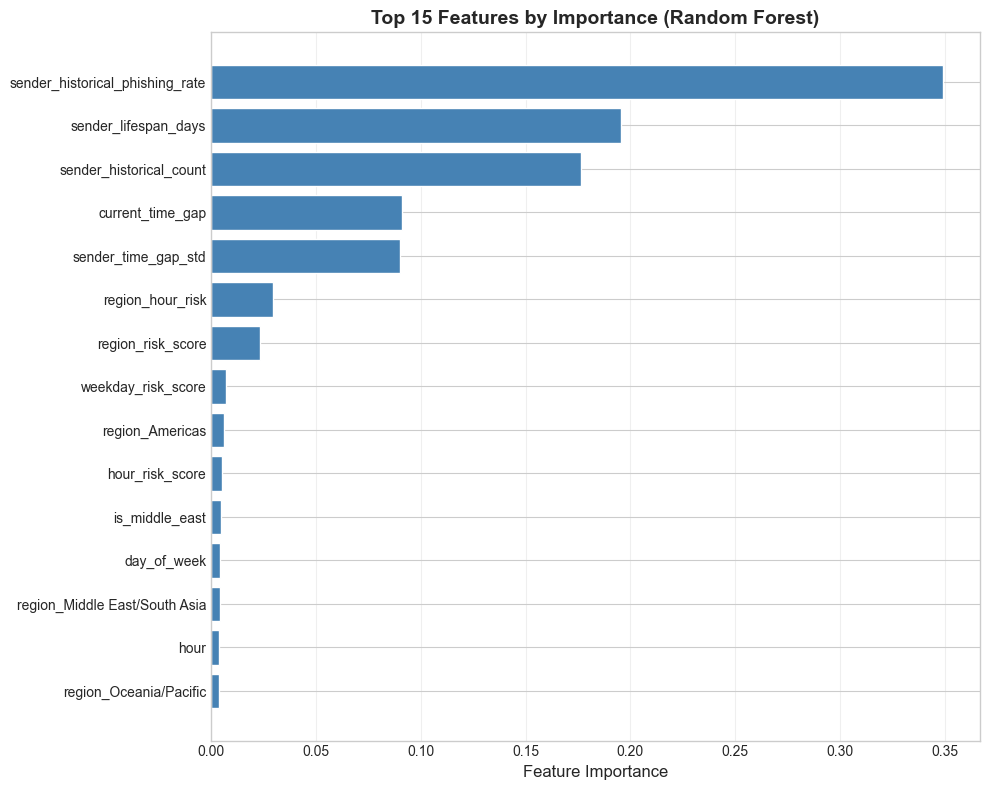

💾 Visualization saved: time_feature_importance.png


In [48]:
# Visualize feature importance
plt.figure(figsize=(10, 8))
top_15 = importance_df.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Feature Importance', fontsize=12)
plt.title('Top 15 Features by Importance (Random Forest)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('time_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("💾 Visualization saved: time_feature_importance.png")

## 2.3 Evaluation Method 2: Statistical Significance Tests

Test if features show significant difference between normal and phishing emails

In [49]:
print("="*80)
print("EVALUATION METHOD 2: STATISTICAL SIGNIFICANCE TESTS")
print("="*80)

# Use original features (before one-hot encoding)
features_original = [col for col in df_final.columns if col != 'label']

# Separate normal and phishing
normal = df_final[df_final['label'] == 0]
spam = df_final[df_final['label'] == 1]

print(f"\n📊 Sample sizes:")
print(f"   Normal (0): {len(normal):,}")
print(f"   Phishing (1): {len(spam):,}")

sig_results = []

print(f"\n🧪 Running statistical tests...")

for feature in features_original:
    if feature == 'timezone_region':
        # Chi-square test for categorical
        contingency_table = pd.crosstab(df_final[feature], df_final['label'])
        chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)
        test_name = 'Chi-square'
    else:
        # T-test for numeric
        normal_vals = normal[feature].dropna()
        spam_vals = spam[feature].dropna()
        t_stat, p_value = stats.ttest_ind(normal_vals, spam_vals)
        test_name = 'T-test'
    
    sig_results.append({
        'feature': feature,
        'test': test_name,
        'p_value': p_value,
        'significant': 'Yes' if p_value < 0.05 else 'No',
        'stars': '***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else ''
    })

sig_df = pd.DataFrame(sig_results).sort_values('p_value')

print(f"\n📊 STATISTICAL SIGNIFICANCE RESULTS:")
print("="*80)
print("Significance levels: *** p<0.001, ** p<0.01, * p<0.05")
print("-"*80)
print(sig_df.to_string(index=False))

# Summary
n_significant = sig_df[sig_df['significant'] == 'Yes'].shape[0]
print(f"\n✅ Significant features (p < 0.05): {n_significant}/{len(features_original)}")

non_sig = sig_df[sig_df['significant'] == 'No']
if len(non_sig) > 0:
    print(f"\n⚠️  Non-significant features (p ≥ 0.05):")
    print(non_sig[['feature', 'p_value']].to_string(index=False))
else:
    print(f"\n✅ All features are statistically significant!")

EVALUATION METHOD 2: STATISTICAL SIGNIFICANCE TESTS

📊 Sample sizes:
   Normal (0): 21,397
   Phishing (1): 27,406

🧪 Running statistical tests...

📊 STATISTICAL SIGNIFICANCE RESULTS:
Significance levels: *** p<0.001, ** p<0.01, * p<0.05
--------------------------------------------------------------------------------
                        feature       test  p_value significant stars
                timezone_region Chi-square   0.0000         Yes   ***
              region_risk_score     T-test   0.0000         Yes   ***
                 is_middle_east     T-test   0.0000         Yes   ***
sender_historical_phishing_rate     T-test   0.0000         Yes   ***
        sender_historical_count     T-test   0.0000         Yes   ***
               region_hour_risk     T-test   0.0000         Yes   ***
                hour_risk_score     T-test   0.0000         Yes   ***
                       is_night     T-test   0.0000         Yes   ***
             weekday_risk_score     T-test   0.0000

## 2.4 Evaluation Method 3: Information Value (Optional)

Calculate IV scores for numeric features

In [50]:
print("="*80)
print("EVALUATION METHOD 3: INFORMATION VALUE (OPTIONAL)")
print("="*80)

def calculate_iv(df, feature, target='label', bins=10):
    """
    Calculate Information Value
    IV < 0.02: Useless
    IV 0.02-0.1: Weak
    IV 0.1-0.3: Medium
    IV 0.3-0.5: Strong
    IV > 0.5: Suspicious
    """
    try:
        df_temp = df[[feature, target]].copy().dropna()
        
        # For binary or small cardinality, don't bin
        if df_temp[feature].nunique() <= 5:
            df_temp['bin'] = df_temp[feature]
        else:
            df_temp['bin'] = pd.qcut(df_temp[feature], q=bins, duplicates='drop')
        
        # Calculate WOE and IV
        grouped = df_temp.groupby('bin')[target].agg(['count', 'sum'])
        grouped['non_target'] = grouped['count'] - grouped['sum']
        
        total_target = grouped['sum'].sum()
        total_non_target = grouped['non_target'].sum()
        
        grouped['pct_target'] = grouped['sum'] / total_target
        grouped['pct_non_target'] = grouped['non_target'] / total_non_target
        
        # Avoid division by zero
        grouped['pct_target'] = grouped['pct_target'].replace(0, 0.0001)
        grouped['pct_non_target'] = grouped['pct_non_target'].replace(0, 0.0001)
        
        grouped['woe'] = np.log(grouped['pct_target'] / grouped['pct_non_target'])
        grouped['iv'] = (grouped['pct_target'] - grouped['pct_non_target']) * grouped['woe']
        
        return grouped['iv'].sum()
    except:
        return np.nan

print(f"\n📊 Calculating Information Value...")

iv_results = []
for feature in features_original:
    if feature != 'timezone_region':  # Skip categorical
        iv = calculate_iv(df_final, feature)
        strength = (
            'Suspicious' if iv > 0.5 else
            'Strong' if iv >= 0.3 else
            'Medium' if iv >= 0.1 else
            'Weak' if iv >= 0.02 else
            'Useless'
        )
        iv_results.append({
            'feature': feature,
            'IV': iv,
            'strength': strength
        })

iv_df = pd.DataFrame(iv_results).sort_values('IV', ascending=False)

print(f"\n📊 INFORMATION VALUE RESULTS:")
print("="*80)
print("IV Interpretation: <0.02=Useless, 0.02-0.1=Weak, 0.1-0.3=Medium, 0.3-0.5=Strong, >0.5=Suspicious")
print("-"*80)
print(iv_df.to_string(index=False))

# Summary by strength
print(f"\n📊 IV Summary:")
iv_summary = iv_df['strength'].value_counts()
for strength, count in iv_summary.items():
    print(f"   {strength}: {count}")

EVALUATION METHOD 3: INFORMATION VALUE (OPTIONAL)

📊 Calculating Information Value...

📊 INFORMATION VALUE RESULTS:
IV Interpretation: <0.02=Useless, 0.02-0.1=Weak, 0.1-0.3=Medium, 0.3-0.5=Strong, >0.5=Suspicious
--------------------------------------------------------------------------------
                        feature     IV   strength
           sender_lifespan_days 2.9178 Suspicious
               current_time_gap 2.7593 Suspicious
        sender_historical_count 2.7542 Suspicious
            sender_time_gap_std 1.7633 Suspicious
               region_hour_risk 0.8001 Suspicious
              region_risk_score 0.7346 Suspicious
                 is_middle_east 0.3741     Strong
sender_historical_phishing_rate 0.3547     Strong
                hour_risk_score 0.1064     Medium
                           hour 0.0848       Weak
                       is_night 0.0333       Weak
                    day_of_week 0.0191    Useless
             weekday_risk_score 0.0185    Useless
      

## 2.4.5 Correlation Analysis

Check for multicollinearity among features to identify highly correlated features that may be redundant.

CORRELATION ANALYSIS

⚠️ Found 3 feature pairs with |correlation| >= 0.8:
        Feature_1                     Feature_2  Correlation  Abs_Correlation
   is_middle_east region_Middle East/South Asia       1.0000           1.0000
region_risk_score              region_hour_risk       0.9225           0.9225
 current_time_gap          sender_lifespan_days       0.8870           0.8870

CORRELATION WITH TARGET VARIABLE

Top 15 features by absolute correlation with target:
                                 Abs_Correlation
sender_historical_phishing_rate           0.8007
region_hour_risk                          0.4046
region_risk_score                         0.3732
sender_historical_count                   0.3145
region_Americas                           0.2662
region_Middle East/South Asia             0.2461
is_middle_east                            0.2461
hour_risk_score                           0.1650
region_Oceania/Pacific                    0.1417
region_APAC                         

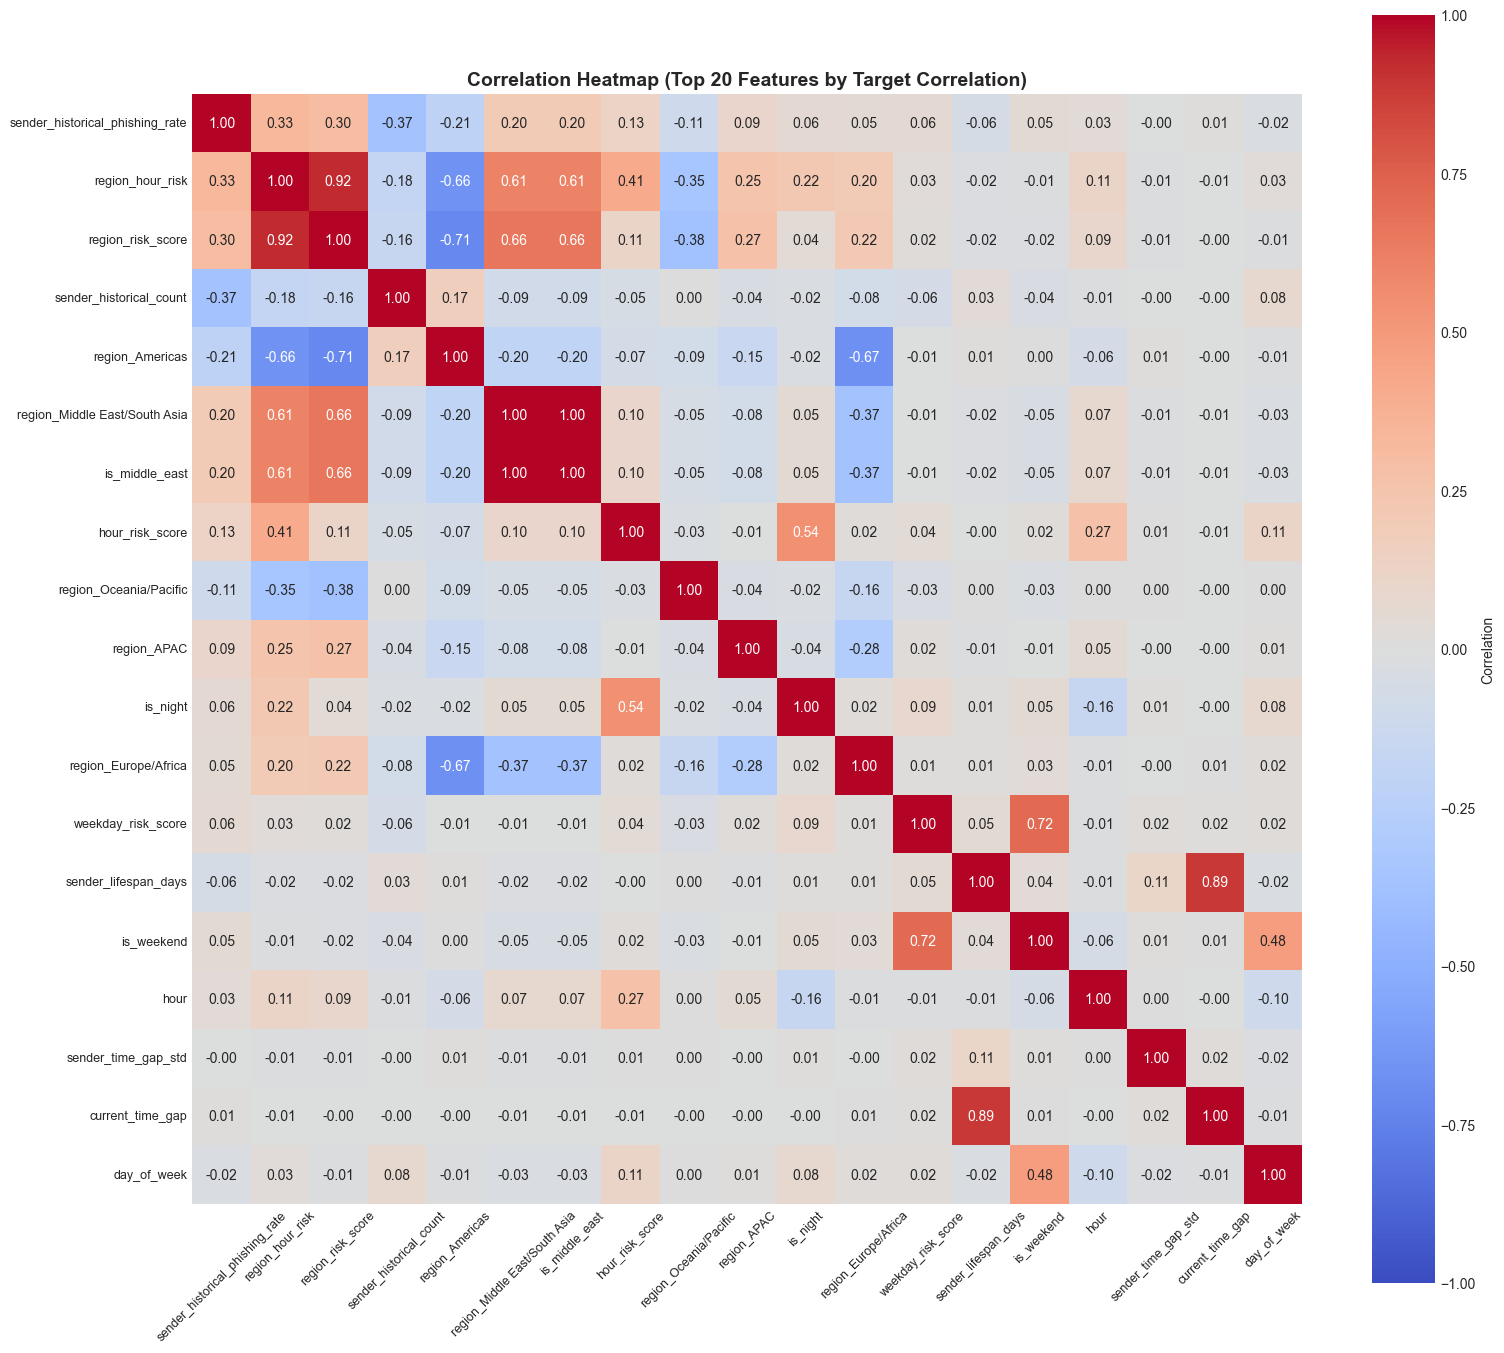


CORRELATION SUMMARY STATISTICS

Total number of features: 19
Number of feature pairs analyzed: 171
Mean absolute correlation: 0.1180
Median absolute correlation: 0.0382
Max absolute correlation: 1.0000
Number of pairs with |corr| >= 0.5: 12
Number of pairs with |corr| >= 0.7: 5
Number of pairs with |corr| >= 0.8: 3

================================🔍 KEY INSIGHTS =================================
⚠️ 3 feature pairs show high correlation (>= 0.8)
   Consider removing one feature from each highly correlated pair to reduce redundancy

📊 Top 3 features most correlated with target:
   1. sender_historical_phishing_rate: 0.8007
   2. region_hour_risk: 0.4046
   3. region_risk_score: 0.3732


In [51]:
print("="*80)
print("CORRELATION ANALYSIS")
print("="*80)

# Calculate correlation matrix for all features
correlation_matrix = X.corr()

# Find feature pairs with high correlation (exclude diagonal)
high_corr_threshold = 0.8
high_corr_pairs = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = abs(correlation_matrix.iloc[i, j])
        if corr_value >= high_corr_threshold:
            high_corr_pairs.append({
                'Feature_1': correlation_matrix.columns[i],
                'Feature_2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j],
                'Abs_Correlation': corr_value
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Abs_Correlation', ascending=False)
    print(f"\n⚠️ Found {len(high_corr_df)} feature pairs with |correlation| >= {high_corr_threshold}:")
    print(high_corr_df.to_string(index=False))
else:
    print(f"\n✅ No feature pairs with |correlation| >= {high_corr_threshold} found.")

# Check correlation with target variable
print("\n" + "="*80)
print("CORRELATION WITH TARGET VARIABLE")
print("="*80)

target_corr = X.corrwith(y).abs().sort_values(ascending=False)
print("\nTop 15 features by absolute correlation with target:")
print(target_corr.head(15).to_frame('Abs_Correlation'))

# Visualization - Only Correlation Heatmap
fig, ax = plt.subplots(1, 1, figsize=(16, 14))

# Correlation heatmap (top features only for readability)
top_features = target_corr.head(20).index.tolist()
corr_subset = correlation_matrix.loc[top_features, top_features]

sns.heatmap(corr_subset, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            vmin=-1, vmax=1, square=True, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation Heatmap (Top 20 Features by Target Correlation)', 
             fontsize=14, fontweight='bold')
ax.tick_params(axis='x', rotation=45, labelsize=9)
ax.tick_params(axis='y', rotation=0, labelsize=9)

plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*80)
print("CORRELATION SUMMARY STATISTICS")
print("="*80)

all_corrs = correlation_matrix.values[np.triu_indices_from(correlation_matrix.values, k=1)]
print(f"\nTotal number of features: {len(correlation_matrix.columns)}")
print(f"Number of feature pairs analyzed: {len(all_corrs)}")
print(f"Mean absolute correlation: {np.abs(all_corrs).mean():.4f}")
print(f"Median absolute correlation: {np.median(np.abs(all_corrs)):.4f}")
print(f"Max absolute correlation: {np.abs(all_corrs).max():.4f}")
print(f"Number of pairs with |corr| >= 0.5: {(np.abs(all_corrs) >= 0.5).sum()}")
print(f"Number of pairs with |corr| >= 0.7: {(np.abs(all_corrs) >= 0.7).sum()}")
print(f"Number of pairs with |corr| >= {high_corr_threshold}: {len(high_corr_pairs)}")

print("\n" + "🔍 KEY INSIGHTS ".center(80, "="))
if high_corr_pairs:
    print(f"⚠️ {len(high_corr_pairs)} feature pairs show high correlation (>= {high_corr_threshold})")
    print("   Consider removing one feature from each highly correlated pair to reduce redundancy")
else:
    print(f"✅ No severe multicollinearity detected (no pairs with |corr| >= {high_corr_threshold})")
print(f"\n📊 Top 3 features most correlated with target:")
for i, (feat, corr) in enumerate(target_corr.head(3).items(), 1):
    print(f"   {i}. {feat}: {corr:.4f}")
print("="*80)

In [52]:
print("="*80)
print("DROPPING HIGHLY CORRELATED / REDUNDANT FEATURES")
print("="*80)

# Features to drop based on correlation analysis
features_to_drop = [
    'is_middle_east',      # Perfect correlation (1.0) with region features
    'region_hour_risk',    # Redundant interaction feature
    'current_time_gap'     # Highly correlated with time gap features
]

print("\n❌ Dropping the following features:")
for feat in features_to_drop:
    if feat in X.columns:
        print(f"   • {feat}")
    else:
        print(f"   • {feat} (not found in dataset)")

# Drop from X (feature matrix)
features_dropped = [f for f in features_to_drop if f in X.columns]
X_cleaned = X.drop(columns=features_dropped)

# Also update train/test sets if they exist
if 'X_train' in locals() and 'X_test' in locals():
    X_train_cleaned = X_train.drop(columns=[f for f in features_dropped if f in X_train.columns])
    X_test_cleaned = X_test.drop(columns=[f for f in features_dropped if f in X_test.columns])
    
    # Update the original X_train and X_test
    X_train = X_train_cleaned
    X_test = X_test_cleaned
    
    print(f"\n✅ Updated train/test sets:")
    print(f"   Training features: {X_train.shape[1]}")
    print(f"   Testing features: {X_test.shape[1]}")

# Update X
X = X_cleaned

print(f"\n✅ Feature dropping complete:")
print(f"   Original features: {len(X.columns) + len(features_dropped)}")
print(f"   Features dropped: {len(features_dropped)}")
print(f"   Remaining features: {len(X.columns)}")
print(f"   Features retained: {list(X.columns)}")

print("="*80)

DROPPING HIGHLY CORRELATED / REDUNDANT FEATURES

❌ Dropping the following features:
   • is_middle_east
   • region_hour_risk
   • current_time_gap

✅ Updated train/test sets:
   Training features: 16
   Testing features: 16

✅ Feature dropping complete:
   Original features: 19
   Features dropped: 3
   Remaining features: 16
   Features retained: ['hour', 'day_of_week', 'is_weekend', 'is_night', 'hour_risk_score', 'weekday_risk_score', 'region_risk_score', 'sender_historical_phishing_rate', 'sender_historical_count', 'sender_time_gap_std', 'sender_lifespan_days', 'region_APAC', 'region_Americas', 'region_Europe/Africa', 'region_Middle East/South Asia', 'region_Oceania/Pacific']


## 2.5 Incremental Feature Group Selection

**New Approach:** Instead of automatic statistical selection, we test feature groups incrementally:

### Strategy:
1. Start with **BASELINE** (original date features only)
2. Add feature groups **ONE BY ONE**
3. Train models and evaluate performance
4. **Keep** group if performance improves
5. **Discard** group if no improvement

### Models:
- **Multinomial Naive Bayes** (baseline classifier)
- **Logistic Regression** (baseline classifier)

### Evaluation Metrics:
- **Accuracy**: Overall correctness
- **Precision**: How many flagged emails are actually phishing
- **Recall**: How many phishing emails are caught
- **F1-Score**: Harmonic mean of precision and recall

### Decision Rule:
Keep feature group if:
- F1-Score improves by ≥ 1% for ANY model
- OR Recall improves by ≥ 2% (catching phishing is critical)

---

### 2.5.1 Remove Highly Correlated Features

Based on correlation analysis, remove redundant features:
- `is_middle_east` (correlation = 1.0 with timezone_region)
- `region_hour_risk` (correlation = 0.92 with region_risk_score, interaction term)
- `current_time_gap` (correlation = 0.89 with sender_lifespan_days)

In [53]:
print("="*80)
print("REMOVING HIGHLY CORRELATED FEATURES")
print("="*80)

# Features to remove based on correlation analysis
features_to_remove = [
    'is_middle_east',      # Perfect correlation with timezone_region
    'region_hour_risk',    # High correlation with region_risk_score
    'current_time_gap'     # High correlation with sender_lifespan_days
]

print(f"\n❌ Removing {len(features_to_remove)} correlated features:")
for feat in features_to_remove:
    print(f"   - {feat}")

# Update features_final
features_final_clean = [f for f in features_final if f not in features_to_remove]

print(f"\n✅ Clean feature set: {len(features_final_clean)} features")
print(f"   Original: {len(features_final)} features")
print(f"   Removed: {len(features_to_remove)} features")

# Update df_final
df_final = df_final[features_final_clean + ['label']].copy()

print(f"\n📊 Updated dataset shape: {df_final.shape}")
print(f"   Features: {df_final.shape[1] - 1}")
print(f"   Samples: {df_final.shape[0]:,}")

REMOVING HIGHLY CORRELATED FEATURES

❌ Removing 3 correlated features:
   - is_middle_east
   - region_hour_risk
   - current_time_gap

✅ Clean feature set: 12 features
   Original: 15 features
   Removed: 3 features

📊 Updated dataset shape: (48803, 13)
   Features: 12
   Samples: 48,803


### 2.5.2 Define Feature Groups

Organize features into logical groups for incremental testing:

In [54]:
print("="*80)
print("DEFINING FEATURE GROUPS")
print("="*80)

# Define feature groups
baseline_features = [
    'hour',
    'day_of_week',
    'is_weekend',
    'is_night'
]

group1_temporal_risk = [
    'hour_risk_score',
    'weekday_risk_score'
]

group2_regional = [
    'timezone_region',
    'region_risk_score'
]

group3_sender_historical = [
    'sender_historical_phishing_rate',
    'sender_historical_count'
]

group4_sender_temporal = [
    'sender_time_gap_std',
    'sender_lifespan_days'
]

# Display groups
print(f"\n📦 BASELINE (Original Date Features): {len(baseline_features)} features")
for feat in baseline_features:
    print(f"   - {feat}")

print(f"\n📦 GROUP 1 (Temporal Risk Scores): {len(group1_temporal_risk)} features")
for feat in group1_temporal_risk:
    print(f"   - {feat}")

print(f"\n📦 GROUP 2 (Regional Features): {len(group2_regional)} features")
for feat in group2_regional:
    print(f"   - {feat}")

print(f"\n📦 GROUP 3 (Sender Historical): {len(group3_sender_historical)} features")
for feat in group3_sender_historical:
    print(f"   - {feat}")

print(f"\n📦 GROUP 4 (Sender Temporal): {len(group4_sender_temporal)} features")
for feat in group4_sender_temporal:
    print(f"   - {feat}")

print(f"\n✅ Total features across all groups: {len(baseline_features + group1_temporal_risk + group2_regional + group3_sender_historical + group4_sender_temporal)}")

# Export selected features to CSV
print("\n" + "="*80)
print("EXPORTING SELECTED FEATURES TO CSV")
print("="*80)

# Combine all selected features
all_selected_features = (baseline_features + group1_temporal_risk + 
                         group2_regional + group3_sender_historical + 
                         group4_sender_temporal)

# Create dataframe with selected features + label
if 'df_final' in locals() or 'df_final' in globals():
    # Check which features exist in df_final
    existing_features = [f for f in all_selected_features if f in df_final.columns]
    missing_features = [f for f in all_selected_features if f not in df_final.columns]
    
    if missing_features:
        print(f"\n⚠️ Warning: {len(missing_features)} features not found in df_final:")
        for feat in missing_features:
            print(f"   - {feat}")
    
    # Export with existing features + label
    features_to_export = existing_features + ['label']
    df_export = df_final[features_to_export].copy()
    
    output_file = "date_data_final_selected_features.csv"
    df_export.to_csv(output_file, index=False)
    
    print(f"\n✅ Successfully exported to: {output_file}")
    print(f"   Shape: {df_export.shape}")
    print(f"   Features: {len(existing_features)}")
    print(f"   Samples: {len(df_export):,}")
    print(f"\n📋 Columns in exported file:")
    for i, col in enumerate(df_export.columns, 1):
        print(f"   {i:2d}. {col}")
else:
    print("\n❌ Error: df_final not found. Please ensure feature engineering is complete.")

print("="*80)

DEFINING FEATURE GROUPS

📦 BASELINE (Original Date Features): 4 features
   - hour
   - day_of_week
   - is_weekend
   - is_night

📦 GROUP 1 (Temporal Risk Scores): 2 features
   - hour_risk_score
   - weekday_risk_score

📦 GROUP 2 (Regional Features): 2 features
   - timezone_region
   - region_risk_score

📦 GROUP 3 (Sender Historical): 2 features
   - sender_historical_phishing_rate
   - sender_historical_count

📦 GROUP 4 (Sender Temporal): 2 features
   - sender_time_gap_std
   - sender_lifespan_days

✅ Total features across all groups: 12

EXPORTING SELECTED FEATURES TO CSV

✅ Successfully exported to: date_data_final_selected_features.csv
   Shape: (48803, 13)
   Features: 12
   Samples: 48,803

📋 Columns in exported file:
    1. hour
    2. day_of_week
    3. is_weekend
    4. is_night
    5. hour_risk_score
    6. weekday_risk_score
    7. timezone_region
    8. region_risk_score
    9. sender_historical_phishing_rate
   10. sender_historical_count
   11. sender_time_gap_std
   

### 2.5.3 Data Preparation

Prepare data for modeling:
- Encode categorical features
- Split train/test
- Scale features for Logistic Regression

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

print("="*80)
print("DATA PREPARATION")
print("="*80)

# Prepare data
all_features = baseline_features + group1_temporal_risk + group2_regional + group3_sender_historical + group4_sender_temporal
X = df_final[all_features].copy()
y = df_final['label'].copy()

print(f"\n📊 Dataset:")
print(f"   Features: {X.shape[1]}")
print(f"   Samples: {X.shape[0]:,}")
print(f"   Phishing rate: {y.mean():.1%}")

# Encode timezone_region (categorical)
print(f"\n🔧 Encoding categorical feature: timezone_region")
le = LabelEncoder()
X['timezone_region'] = le.fit_transform(X['timezone_region'])
print(f"   Encoded to: {X['timezone_region'].nunique()} numeric values")

# Train/test split (stratified)
print(f"\n✂️ Splitting data: 70% train, 30% test (stratified)")
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print(f"   Train: {X_train.shape[0]:,} samples")
print(f"   Test:  {X_test.shape[0]:,} samples")
print(f"   Train phishing rate: {y_train.mean():.1%}")
print(f"   Test phishing rate:  {y_test.mean():.1%}")

# Prepare scaler for Logistic Regression
print(f"\n⚖️ Preparing StandardScaler for Logistic Regression")
scaler = StandardScaler()
print(f"   Will be applied during each experiment")

print(f"\n✅ Data preparation complete!")

DATA PREPARATION

📊 Dataset:
   Features: 12
   Samples: 48,803
   Phishing rate: 56.2%

🔧 Encoding categorical feature: timezone_region
   Encoded to: 5 numeric values

✂️ Splitting data: 70% train, 30% test (stratified)
   Train: 34,162 samples
   Test:  14,641 samples
   Train phishing rate: 56.2%
   Test phishing rate:  56.2%

⚖️ Preparing StandardScaler for Logistic Regression
   Will be applied during each experiment

✅ Data preparation complete!


### 2.5.4 Evaluation Function

Define function to train and evaluate models:

In [56]:
def evaluate_model(X_train, X_test, y_train, y_test, model_type, feature_set_name, feature_list):
    """
    Train and evaluate a model
    
    Parameters:
    -----------
    X_train, X_test : DataFrame
        Training and test features
    y_train, y_test : Series
        Training and test labels
    model_type : str
        'nb' for Naive Bayes or 'lr' for Logistic Regression
    feature_set_name : str
        Name of feature set (e.g., 'Baseline', 'Baseline+G1')
    feature_list : list
        List of feature names
    
    Returns:
    --------
    dict : Evaluation metrics
    """
    
    # Select features
    X_train_subset = X_train[feature_list].copy()
    X_test_subset = X_test[feature_list].copy()
    
    if model_type == 'nb':
        # Multinomial Naive Bayes
        # Ensure non-negative values (required by MultinomialNB)
        X_train_subset = X_train_subset - X_train_subset.min() + 1e-10
        X_test_subset = X_test_subset - X_test_subset.min() + 1e-10
        
        model = MultinomialNB(alpha=1.0)
        model_name = 'Multinomial NB'
        
    elif model_type == 'lr':
        # Logistic Regression with scaling
        scaler_local = StandardScaler()
        X_train_subset = scaler_local.fit_transform(X_train_subset)
        X_test_subset = scaler_local.transform(X_test_subset)
        
        model = LogisticRegression(
            penalty='l2',
            C=1.0,
            class_weight='balanced',
            max_iter=1000,
            random_state=42
        )
        model_name = 'Logistic Regression'
    
    # Train
    model.fit(X_train_subset, y_train)
    
    # Predict
    y_pred = model.predict(X_test_subset)
    
    # Calculate metrics
    metrics = {
        'feature_set': feature_set_name,
        'model': model_name,
        'n_features': len(feature_list),
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }
    
    return metrics, model

print("✅ Evaluation function defined")

✅ Evaluation function defined


### 2.5.5 Run Incremental Experiments

Test each feature group incrementally and decide whether to keep or discard.

In [57]:
print("="*80)
print("INCREMENTAL FEATURE GROUP TESTING")
print("="*80)

# Store results
results = []
best_features = baseline_features.copy()
improvement_threshold_f1 = 0.01  # 1% improvement in F1
improvement_threshold_recall = 0.02  # 2% improvement in Recall

# ============================================================
# EXPERIMENT 1: BASELINE
# ============================================================
print("\n" + "="*80)
print("EXPERIMENT 1: BASELINE (Original Date Features)")
print("="*80)
print(f"Features ({len(baseline_features)}): {baseline_features}")

# Train Multinomial NB
metrics_nb, model_nb = evaluate_model(
    X_train, X_test, y_train, y_test,
    'nb', 'Baseline', baseline_features
)
results.append(metrics_nb)

# Train Logistic Regression
metrics_lr, model_lr = evaluate_model(
    X_train, X_test, y_train, y_test,
    'lr', 'Baseline', baseline_features
)
results.append(metrics_lr)

# Display results
print(f"\n📊 Multinomial NB:")
print(f"   Accuracy:  {metrics_nb['accuracy']:.4f}")
print(f"   Precision: {metrics_nb['precision']:.4f}")
print(f"   Recall:    {metrics_nb['recall']:.4f}")
print(f"   F1-Score:  {metrics_nb['f1_score']:.4f}")

print(f"\n📊 Logistic Regression:")
print(f"   Accuracy:  {metrics_lr['accuracy']:.4f}")
print(f"   Precision: {metrics_lr['precision']:.4f}")
print(f"   Recall:    {metrics_lr['recall']:.4f}")
print(f"   F1-Score:  {metrics_lr['f1_score']:.4f}")

# Track best scores
best_f1 = max(metrics_nb['f1_score'], metrics_lr['f1_score'])
best_recall = max(metrics_nb['recall'], metrics_lr['recall'])

print(f"\n🎯 Baseline Best Scores:")
print(f"   F1-Score: {best_f1:.4f}")
print(f"   Recall:   {best_recall:.4f}")

INCREMENTAL FEATURE GROUP TESTING

EXPERIMENT 1: BASELINE (Original Date Features)
Features (4): ['hour', 'day_of_week', 'is_weekend', 'is_night']

📊 Multinomial NB:
   Accuracy:  0.5616
   Precision: 0.5616
   Recall:    1.0000
   F1-Score:  0.7192

📊 Logistic Regression:
   Accuracy:  0.5387
   Precision: 0.6314
   Recall:    0.4288
   F1-Score:  0.5108

🎯 Baseline Best Scores:
   F1-Score: 0.7192
   Recall:   1.0000


In [58]:
# ============================================================
# EXPERIMENT 2: + GROUP 1 (Temporal Risk Scores)
# ============================================================
print("\n" + "="*80)
print("EXPERIMENT 2: BASELINE + GROUP 1 (Temporal Risk Scores)")
print("="*80)

candidate_features = best_features + group1_temporal_risk
print(f"Features ({len(candidate_features)}): {candidate_features}")

# Train both models
metrics_nb, _ = evaluate_model(
    X_train, X_test, y_train, y_test,
    'nb', 'Baseline+G1', candidate_features
)
results.append(metrics_nb)

metrics_lr, _ = evaluate_model(
    X_train, X_test, y_train, y_test,
    'lr', 'Baseline+G1', candidate_features
)
results.append(metrics_lr)

# Display results
print(f"\n📊 Multinomial NB:")
print(f"   Accuracy:  {metrics_nb['accuracy']:.4f}")
print(f"   Precision: {metrics_nb['precision']:.4f}")
print(f"   Recall:    {metrics_nb['recall']:.4f}")
print(f"   F1-Score:  {metrics_nb['f1_score']:.4f} (Δ: {metrics_nb['f1_score'] - best_f1:+.4f})")

print(f"\n📊 Logistic Regression:")
print(f"   Accuracy:  {metrics_lr['accuracy']:.4f}")
print(f"   Precision: {metrics_lr['precision']:.4f}")
print(f"   Recall:    {metrics_lr['recall']:.4f}")
print(f"   F1-Score:  {metrics_lr['f1_score']:.4f} (Δ: {metrics_lr['f1_score'] - best_f1:+.4f})")

# Decision
current_best_f1 = max(metrics_nb['f1_score'], metrics_lr['f1_score'])
current_best_recall = max(metrics_nb['recall'], metrics_lr['recall'])

f1_improvement = current_best_f1 - best_f1
recall_improvement = current_best_recall - best_recall

if f1_improvement >= improvement_threshold_f1 or recall_improvement >= improvement_threshold_recall:
    decision = "✅ KEEP"
    best_features = candidate_features.copy()
    best_f1 = current_best_f1
    best_recall = current_best_recall
else:
    decision = "❌ DISCARD"

print(f"\n🎯 Decision: {decision} Group 1")
print(f"   F1 improvement: {f1_improvement:+.4f} (threshold: {improvement_threshold_f1:.4f})")
print(f"   Recall improvement: {recall_improvement:+.4f} (threshold: {improvement_threshold_recall:.4f})")


EXPERIMENT 2: BASELINE + GROUP 1 (Temporal Risk Scores)
Features (6): ['hour', 'day_of_week', 'is_weekend', 'is_night', 'hour_risk_score', 'weekday_risk_score']

📊 Multinomial NB:
   Accuracy:  0.5616
   Precision: 0.5616
   Recall:    1.0000
   F1-Score:  0.7192 (Δ: +0.0000)

📊 Logistic Regression:
   Accuracy:  0.5838
   Precision: 0.6333
   Recall:    0.6149
   F1-Score:  0.6240 (Δ: -0.0952)

🎯 Decision: ❌ DISCARD Group 1
   F1 improvement: +0.0000 (threshold: 0.0100)
   Recall improvement: +0.0000 (threshold: 0.0200)


In [59]:
# ============================================================
# EXPERIMENT 3: BEST SO FAR + GROUP 2 (Regional)
# ============================================================
print("\n" + "="*80)
print("EXPERIMENT 3: BEST SO FAR + GROUP 2 (Regional Features)")
print("="*80)

candidate_features = best_features + group2_regional
print(f"Features ({len(candidate_features)}): {candidate_features}")

# Train both models
metrics_nb, _ = evaluate_model(
    X_train, X_test, y_train, y_test,
    'nb', 'Best+G2', candidate_features
)
results.append(metrics_nb)

metrics_lr, _ = evaluate_model(
    X_train, X_test, y_train, y_test,
    'lr', 'Best+G2', candidate_features
)
results.append(metrics_lr)

# Display results
print(f"\n📊 Multinomial NB:")
print(f"   Accuracy:  {metrics_nb['accuracy']:.4f}")
print(f"   Precision: {metrics_nb['precision']:.4f}")
print(f"   Recall:    {metrics_nb['recall']:.4f}")
print(f"   F1-Score:  {metrics_nb['f1_score']:.4f} (Δ: {metrics_nb['f1_score'] - best_f1:+.4f})")

print(f"\n📊 Logistic Regression:")
print(f"   Accuracy:  {metrics_lr['accuracy']:.4f}")
print(f"   Precision: {metrics_lr['precision']:.4f}")
print(f"   Recall:    {metrics_lr['recall']:.4f}")
print(f"   F1-Score:  {metrics_lr['f1_score']:.4f} (Δ: {metrics_lr['f1_score'] - best_f1:+.4f})")

# Decision
current_best_f1 = max(metrics_nb['f1_score'], metrics_lr['f1_score'])
current_best_recall = max(metrics_nb['recall'], metrics_lr['recall'])

f1_improvement = current_best_f1 - best_f1
recall_improvement = current_best_recall - best_recall

if f1_improvement >= improvement_threshold_f1 or recall_improvement >= improvement_threshold_recall:
    decision = "✅ KEEP"
    best_features = candidate_features.copy()
    best_f1 = current_best_f1
    best_recall = current_best_recall
else:
    decision = "❌ DISCARD"

print(f"\n🎯 Decision: {decision} Group 2")
print(f"   F1 improvement: {f1_improvement:+.4f} (threshold: {improvement_threshold_f1:.4f})")
print(f"   Recall improvement: {recall_improvement:+.4f} (threshold: {improvement_threshold_recall:.4f})")


EXPERIMENT 3: BEST SO FAR + GROUP 2 (Regional Features)
Features (6): ['hour', 'day_of_week', 'is_weekend', 'is_night', 'timezone_region', 'region_risk_score']

📊 Multinomial NB:
   Accuracy:  0.5784
   Precision: 0.5725
   Recall:    0.9848
   F1-Score:  0.7240 (Δ: +0.0048)

📊 Logistic Regression:
   Accuracy:  0.6723
   Precision: 0.6745
   Recall:    0.8049
   F1-Score:  0.7339 (Δ: +0.0147)

🎯 Decision: ✅ KEEP Group 2
   F1 improvement: +0.0147 (threshold: 0.0100)
   Recall improvement: -0.0152 (threshold: 0.0200)


In [60]:
# ============================================================
# EXPERIMENT 4: BEST SO FAR + GROUP 3 (Sender Historical)
# ============================================================
print("\n" + "="*80)
print("EXPERIMENT 4: BEST SO FAR + GROUP 3 (Sender Historical)")
print("="*80)

candidate_features = best_features + group3_sender_historical
print(f"Features ({len(candidate_features)}): {candidate_features}")

# Train both models
metrics_nb, _ = evaluate_model(
    X_train, X_test, y_train, y_test,
    'nb', 'Best+G3', candidate_features
)
results.append(metrics_nb)

metrics_lr, _ = evaluate_model(
    X_train, X_test, y_train, y_test,
    'lr', 'Best+G3', candidate_features
)
results.append(metrics_lr)

# Display results
print(f"\n📊 Multinomial NB:")
print(f"   Accuracy:  {metrics_nb['accuracy']:.4f}")
print(f"   Precision: {metrics_nb['precision']:.4f}")
print(f"   Recall:    {metrics_nb['recall']:.4f}")
print(f"   F1-Score:  {metrics_nb['f1_score']:.4f} (Δ: {metrics_nb['f1_score'] - best_f1:+.4f})")

print(f"\n📊 Logistic Regression:")
print(f"   Accuracy:  {metrics_lr['accuracy']:.4f}")
print(f"   Precision: {metrics_lr['precision']:.4f}")
print(f"   Recall:    {metrics_lr['recall']:.4f}")
print(f"   F1-Score:  {metrics_lr['f1_score']:.4f} (Δ: {metrics_lr['f1_score'] - best_f1:+.4f})")

# Decision
current_best_f1 = max(metrics_nb['f1_score'], metrics_lr['f1_score'])
current_best_recall = max(metrics_nb['recall'], metrics_lr['recall'])

f1_improvement = current_best_f1 - best_f1
recall_improvement = current_best_recall - best_recall

if f1_improvement >= improvement_threshold_f1 or recall_improvement >= improvement_threshold_recall:
    decision = "✅ KEEP"
    best_features = candidate_features.copy()
    best_f1 = current_best_f1
    best_recall = current_best_recall
else:
    decision = "❌ DISCARD"

print(f"\n🎯 Decision: {decision} Group 3")
print(f"   F1 improvement: {f1_improvement:+.4f} (threshold: {improvement_threshold_f1:.4f})")
print(f"   Recall improvement: {recall_improvement:+.4f} (threshold: {improvement_threshold_recall:.4f})")


EXPERIMENT 4: BEST SO FAR + GROUP 3 (Sender Historical)
Features (8): ['hour', 'day_of_week', 'is_weekend', 'is_night', 'timezone_region', 'region_risk_score', 'sender_historical_phishing_rate', 'sender_historical_count']

📊 Multinomial NB:
   Accuracy:  0.7977
   Precision: 0.7396
   Recall:    0.9874
   F1-Score:  0.8457 (Δ: +0.1118)

📊 Logistic Regression:
   Accuracy:  0.9083
   Precision: 0.8611
   Recall:    0.9977
   F1-Score:  0.9244 (Δ: +0.1904)

🎯 Decision: ✅ KEEP Group 3
   F1 improvement: +0.1904 (threshold: 0.0100)
   Recall improvement: +0.0129 (threshold: 0.0200)


In [61]:
# ============================================================
# EXPERIMENT 5: BEST SO FAR + GROUP 4 (Sender Temporal)
# ============================================================
print("\n" + "="*80)
print("EXPERIMENT 5: BEST SO FAR + GROUP 4 (Sender Temporal)")
print("="*80)

candidate_features = best_features + group4_sender_temporal
print(f"Features ({len(candidate_features)}): {candidate_features}")

# Train both models
metrics_nb, _ = evaluate_model(
    X_train, X_test, y_train, y_test,
    'nb', 'Best+G4', candidate_features
)
results.append(metrics_nb)

metrics_lr, _ = evaluate_model(
    X_train, X_test, y_train, y_test,
    'lr', 'Best+G4', candidate_features
)
results.append(metrics_lr)

# Display results
print(f"\n📊 Multinomial NB:")
print(f"   Accuracy:  {metrics_nb['accuracy']:.4f}")
print(f"   Precision: {metrics_nb['precision']:.4f}")
print(f"   Recall:    {metrics_nb['recall']:.4f}")
print(f"   F1-Score:  {metrics_nb['f1_score']:.4f} (Δ: {metrics_nb['f1_score'] - best_f1:+.4f})")

print(f"\n📊 Logistic Regression:")
print(f"   Accuracy:  {metrics_lr['accuracy']:.4f}")
print(f"   Precision: {metrics_lr['precision']:.4f}")
print(f"   Recall:    {metrics_lr['recall']:.4f}")
print(f"   F1-Score:  {metrics_lr['f1_score']:.4f} (Δ: {metrics_lr['f1_score'] - best_f1:+.4f})")

# Decision
current_best_f1 = max(metrics_nb['f1_score'], metrics_lr['f1_score'])
current_best_recall = max(metrics_nb['recall'], metrics_lr['recall'])

f1_improvement = current_best_f1 - best_f1
recall_improvement = current_best_recall - best_recall

if f1_improvement >= improvement_threshold_f1 or recall_improvement >= improvement_threshold_recall:
    decision = "✅ KEEP"
    best_features = candidate_features.copy()
    best_f1 = current_best_f1
    best_recall = current_best_recall
else:
    decision = "❌ DISCARD"

print(f"\n🎯 Decision: {decision} Group 4")
print(f"   F1 improvement: {f1_improvement:+.4f} (threshold: {improvement_threshold_f1:.4f})")
print(f"   Recall improvement: {recall_improvement:+.4f} (threshold: {improvement_threshold_recall:.4f})")


EXPERIMENT 5: BEST SO FAR + GROUP 4 (Sender Temporal)
Features (10): ['hour', 'day_of_week', 'is_weekend', 'is_night', 'timezone_region', 'region_risk_score', 'sender_historical_phishing_rate', 'sender_historical_count', 'sender_time_gap_std', 'sender_lifespan_days']

📊 Multinomial NB:
   Accuracy:  0.7969
   Precision: 0.7393
   Recall:    0.9859
   F1-Score:  0.8450 (Δ: -0.0794)

📊 Logistic Regression:
   Accuracy:  0.9083
   Precision: 0.8611
   Recall:    0.9976
   F1-Score:  0.9243 (Δ: -0.0001)

🎯 Decision: ❌ DISCARD Group 4
   F1 improvement: -0.0001 (threshold: 0.0100)
   Recall improvement: -0.0001 (threshold: 0.0200)


### 2.5.6 Results Summary

Comprehensive summary of all experiments:

In [62]:
print("\n" + "="*80)
print("RESULTS SUMMARY")
print("="*80)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results table
print(f"\n📊 All Experiments:")
print("="*80)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.4f}'.format)
print(results_df.to_string(index=False))

# Find best model
best_idx = results_df['f1_score'].idxmax()
best_model_results = results_df.iloc[best_idx]

print(f"\n" + "="*80)
print("🏆 BEST MODEL")
print("="*80)
print(f"\nFeature Set: {best_model_results['feature_set']}")
print(f"Model: {best_model_results['model']}")
print(f"Number of Features: {best_model_results['n_features']}")
print(f"\nPerformance:")
print(f"   Accuracy:  {best_model_results['accuracy']:.4f}")
print(f"   Precision: {best_model_results['precision']:.4f}")
print(f"   Recall:    {best_model_results['recall']:.4f}")
print(f"   F1-Score:  {best_model_results['f1_score']:.4f}")

# Show selected features
print(f"\n" + "="*80)
print("✅ FINAL SELECTED FEATURES")
print("="*80)
print(f"\nTotal: {len(best_features)} features")
for i, feat in enumerate(best_features, 1):
    print(f"   {i}. {feat}")

# Store for later use
final_selected_features = best_features.copy()
print(f"\n✅ Features stored in variable: final_selected_features")


RESULTS SUMMARY

📊 All Experiments:
feature_set               model  n_features  accuracy  precision  recall  f1_score
   Baseline      Multinomial NB           4    0.5616     0.5616  1.0000    0.7192
   Baseline Logistic Regression           4    0.5387     0.6314  0.4288    0.5108
Baseline+G1      Multinomial NB           6    0.5616     0.5616  1.0000    0.7192
Baseline+G1 Logistic Regression           6    0.5838     0.6333  0.6149    0.6240
    Best+G2      Multinomial NB           6    0.5784     0.5725  0.9848    0.7240
    Best+G2 Logistic Regression           6    0.6723     0.6745  0.8049    0.7339
    Best+G3      Multinomial NB           8    0.7977     0.7396  0.9874    0.8457
    Best+G3 Logistic Regression           8    0.9083     0.8611  0.9977    0.9244
    Best+G4      Multinomial NB          10    0.7969     0.7393  0.9859    0.8450
    Best+G4 Logistic Regression          10    0.9083     0.8611  0.9976    0.9243

🏆 BEST MODEL

Feature Set: Best+G3
Model: Logisti

### 2.5.7 Visualization

Visualize performance across experiments:

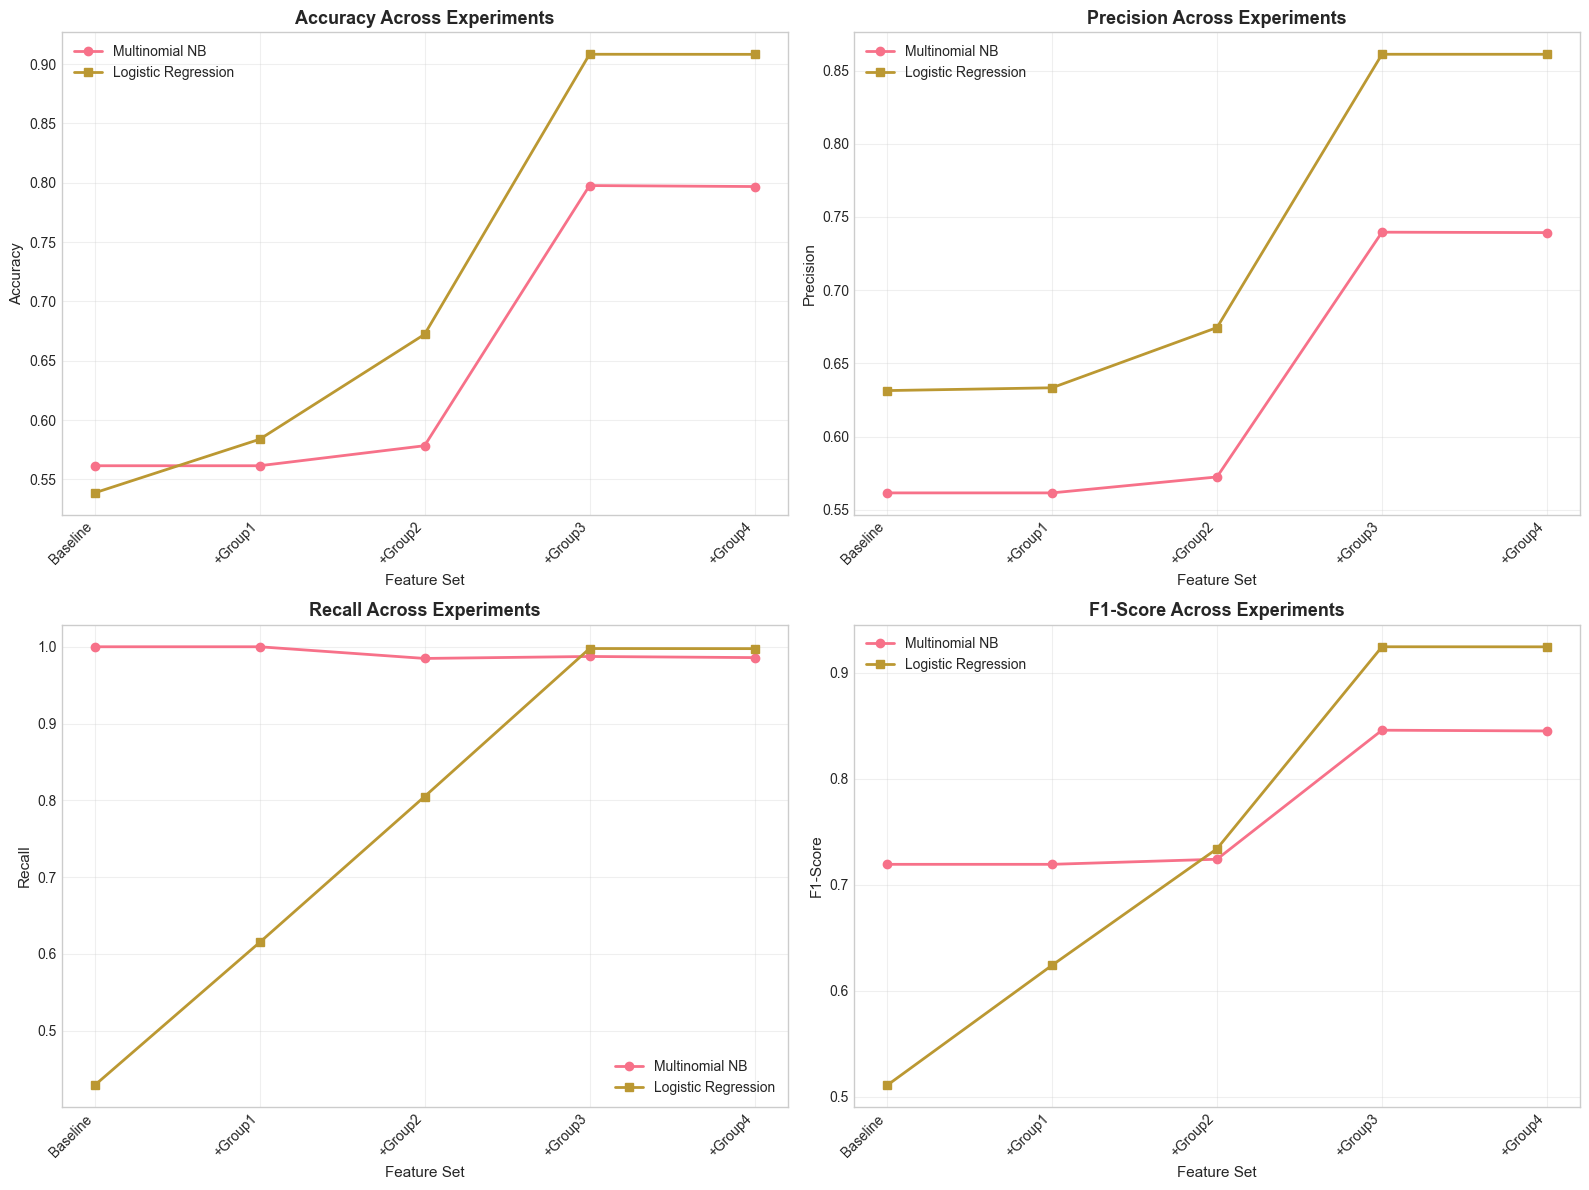

✅ Visualizations complete!


In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 10)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Prepare data for plotting
nb_results = results_df[results_df['model'] == 'Multinomial NB'].reset_index(drop=True)
lr_results = results_df[results_df['model'] == 'Logistic Regression'].reset_index(drop=True)

x_labels = ['Baseline', '+Group1', '+Group2', '+Group3', '+Group4']
x_pos = range(len(x_labels))

# Plot 1: Accuracy Comparison
axes[0, 0].plot(x_pos, nb_results['accuracy'], marker='o', label='Multinomial NB', linewidth=2)
axes[0, 0].plot(x_pos, lr_results['accuracy'], marker='s', label='Logistic Regression', linewidth=2)
axes[0, 0].set_xlabel('Feature Set', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Accuracy Across Experiments', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(x_labels, rotation=45, ha='right')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Precision Comparison
axes[0, 1].plot(x_pos, nb_results['precision'], marker='o', label='Multinomial NB', linewidth=2)
axes[0, 1].plot(x_pos, lr_results['precision'], marker='s', label='Logistic Regression', linewidth=2)
axes[0, 1].set_xlabel('Feature Set', fontsize=11)
axes[0, 1].set_ylabel('Precision', fontsize=11)
axes[0, 1].set_title('Precision Across Experiments', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(x_labels, rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Recall Comparison
axes[1, 0].plot(x_pos, nb_results['recall'], marker='o', label='Multinomial NB', linewidth=2)
axes[1, 0].plot(x_pos, lr_results['recall'], marker='s', label='Logistic Regression', linewidth=2)
axes[1, 0].set_xlabel('Feature Set', fontsize=11)
axes[1, 0].set_ylabel('Recall', fontsize=11)
axes[1, 0].set_title('Recall Across Experiments', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(x_labels, rotation=45, ha='right')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: F1-Score Comparison
axes[1, 1].plot(x_pos, nb_results['f1_score'], marker='o', label='Multinomial NB', linewidth=2)
axes[1, 1].plot(x_pos, lr_results['f1_score'], marker='s', label='Logistic Regression', linewidth=2)
axes[1, 1].set_xlabel('Feature Set', fontsize=11)
axes[1, 1].set_ylabel('F1-Score', fontsize=11)
axes[1, 1].set_title('F1-Score Across Experiments', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(x_labels, rotation=45, ha='right')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualizations complete!")